In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_moons
from tqdm import tqdm

# ==========================================
# 1. Configuration
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

INTRINSIC_DIM = 2      # true manifold dimension
AMBIENT_DIM = 32      # high-dimensional ambient space

print(f"Running on {DEVICE} with Ambient Dimension D={AMBIENT_DIM}")

Running on cuda with Ambient Dimension D=32


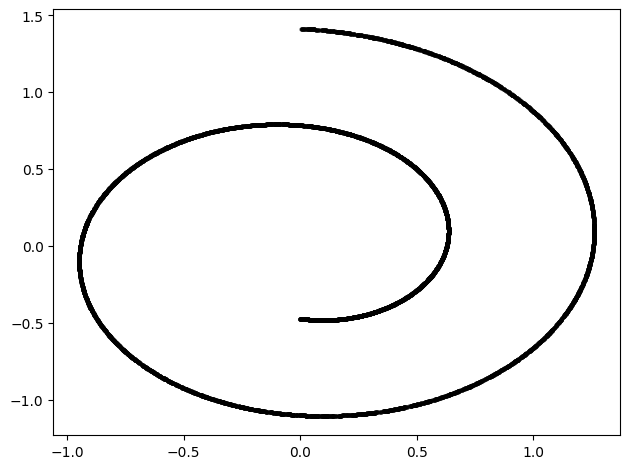

In [89]:
# ==========================================
# 2. Data + Random Orthogonal Embedding
# ==========================================
def get_data(batch_size: int, data_type: str) -> np.ndarray:
    if data_type == "swiss_roll":
        data, _ = make_swiss_roll(batch_size)
        data = data[:, [0, 2]] / 10.0
    elif data_type == "moons":
        data, _ = make_moons(batch_size)
    return data

# random orthogonal projection 2 → D
Q = torch.randn(AMBIENT_DIM, INTRINSIC_DIM, device=DEVICE)
Q, _ = torch.linalg.qr(Q)

def embed(x2d):
    return x2d @ Q.T

def project_back(xD):
    return xD @ Q

n_points = 8192
data_type = "swiss_roll"
data = get_data(n_points, data_type)

plt.scatter(data[:,0], data[:,1], s=5, c='black', alpha=0.5)
plt.tight_layout()
plt.show()

In [90]:
batch_size = 1024
dataset = torch.from_numpy(data).float().to(DEVICE)
dataset = TensorDataset(dataset) 
dataloader = DataLoader(dataset, batch_size=batch_size)

In [91]:
# ==========================================
# 3. Model (MLP)
# ==========================================
class DenoisingMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.time_encoder = nn.Sequential(
            nn.Linear(1, 20), nn.ReLU(),
        )

        self.net = nn.Sequential(
            nn.Linear(dim + 20, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, dim)
        )

    def forward(self, x, t):
        t_emb = self.time_encoder(t)
        out = self.net(torch.cat((x, t_emb), dim=-1))
        return out

In [92]:
# ==================================================
# 4. Loss (x, eps, v prediction) * (x, eps, v loss)
# ==================================================
def compute_loss(x1, eps, xt, t, pred_raw, pred_type, loss_type):
    if loss_type == "v":
        if pred_type == "x":
            x1_hat = pred_raw
            v_hat = (x1_hat - xt) / (1-t)
        elif pred_type == "eps":
            eps_hat = pred_raw
            v_hat = (xt - eps_hat) / t
        elif pred_type == "v":
            v_hat = pred_raw
        v_target = x1 - eps
        return ((v_hat - v_target)**2).mean()
    
    elif loss_type == "x":
        if pred_type == "x":
            x1_hat = pred_raw
        elif pred_type == "eps":
            eps_hat = pred_raw
            x1_hat = (xt - eps_hat*(1-t)) / t
        elif pred_type == "v":
            v_hat = pred_raw
            x1_hat = xt + (1 - t) * v_hat
        return ((x1_hat - x1)**2).mean()

    elif loss_type == "eps":
        if pred_type == "x":
            x1_hat = pred_raw
            eps_hat = (xt - t*x1_hat) / (1 - t)
        elif pred_type == "eps":
            eps_hat = pred_raw
        elif pred_type == "v":
            v_hat = pred_raw
            eps_hat = xt - t * v_hat
        return ((eps_hat - eps)**2).mean()

In [93]:
# ==========================================
# 5. Training (x, eps, v prediction)
# ==========================================
def train_model(pred_type="x", loss_type="v", train_steps=1000):
    assert pred_type in ["x", "eps", "v"]
    assert loss_type in ["x", "eps", "v"]
    model = DenoisingMLP(AMBIENT_DIM).to(DEVICE)
    optim_ = optim.Adam(model.parameters(), lr=1e-3)

    print(f"Training {pred_type}-prediction model with {loss_type} loss...")
    t_eps = 1e-2
    losses = []

    for step in tqdm(range(train_steps)):
        for batch in dataloader:
            x1_low = batch[0]
            x1 = embed(x1_low)
            eps = torch.randn_like(x1)
            t = torch.rand((x1.shape[0], 1), device=DEVICE)
            t = t.clip(t_eps, 1 - t_eps)
            xt = t * x1 + (1 - t) * eps

            pred_raw = model(xt, t)
            
            loss = compute_loss(x1, eps, xt, t, pred_raw, pred_type, loss_type)
            losses.append(loss.item())
            optim_.zero_grad()
            loss.backward()
            optim_.step()

    return model, losses

loss_type = "v"   # v, x, eps
train_steps = 3000

model_x, losses_x = train_model("x", loss_type, train_steps)
model_eps, losses_eps = train_model("eps", loss_type, train_steps)
model_v, losses_v = train_model("v", loss_type, train_steps)

Training x-prediction model with v loss...


100%|██████████| 3000/3000 [01:22<00:00, 36.29it/s]


Training eps-prediction model with v loss...


100%|██████████| 3000/3000 [01:19<00:00, 37.88it/s]


Training v-prediction model with v loss...


100%|██████████| 3000/3000 [01:21<00:00, 36.90it/s]


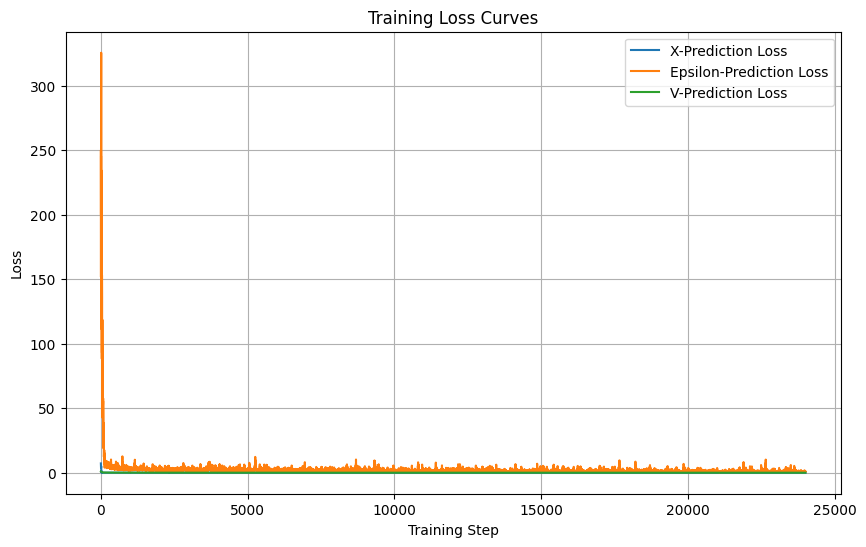

In [94]:
# Visualize the training loss curves
plt.figure(figsize=(10, 6))
plt.plot(losses_x, label='X-Prediction Loss')
plt.plot(losses_eps, label='Epsilon-Prediction Loss')
plt.plot(losses_v, label='V-Prediction Loss')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# ==========================================
# 6. Sampling
# ==========================================
@torch.no_grad()
def sample(model, pred_type, num_samples=2000, steps=50):
    x_t = torch.randn(num_samples, AMBIENT_DIM, device=DEVICE)
    eps_t = 1e-2
    ts = torch.linspace(eps_t, 1 - eps_t, steps, device=DEVICE)
    ts = ts.unsqueeze(0).repeat(num_samples, 1)
    interval = ts[:, 1:2] - ts[:, 0:1]

    for i in range(steps):
        t = ts[:, i:i+1]
        pred_raw = model(x_t, t)

        if pred_type == "x":
            x1_hat = pred_raw
            v_hat = (x1_hat - x_t) / (1-t)
        elif pred_type == "eps":
            eps_hat = pred_raw
            v_hat = (x_t - eps_hat) / t
        elif pred_type == "v":
            v_hat = pred_raw
        x_t = x_t + v_hat * interval

    return x_t


samples_x = sample(model_x, "x", n_points)
samples_eps = sample(model_eps, "eps", n_points)
samples_v = sample(model_v, "v", n_points)

# Project back to 2D
x_orig = data
x_pred_x = project_back(samples_x).cpu().numpy()
x_pred_eps = project_back(samples_eps).cpu().numpy()
x_pred_v = project_back(samples_v).cpu().numpy()

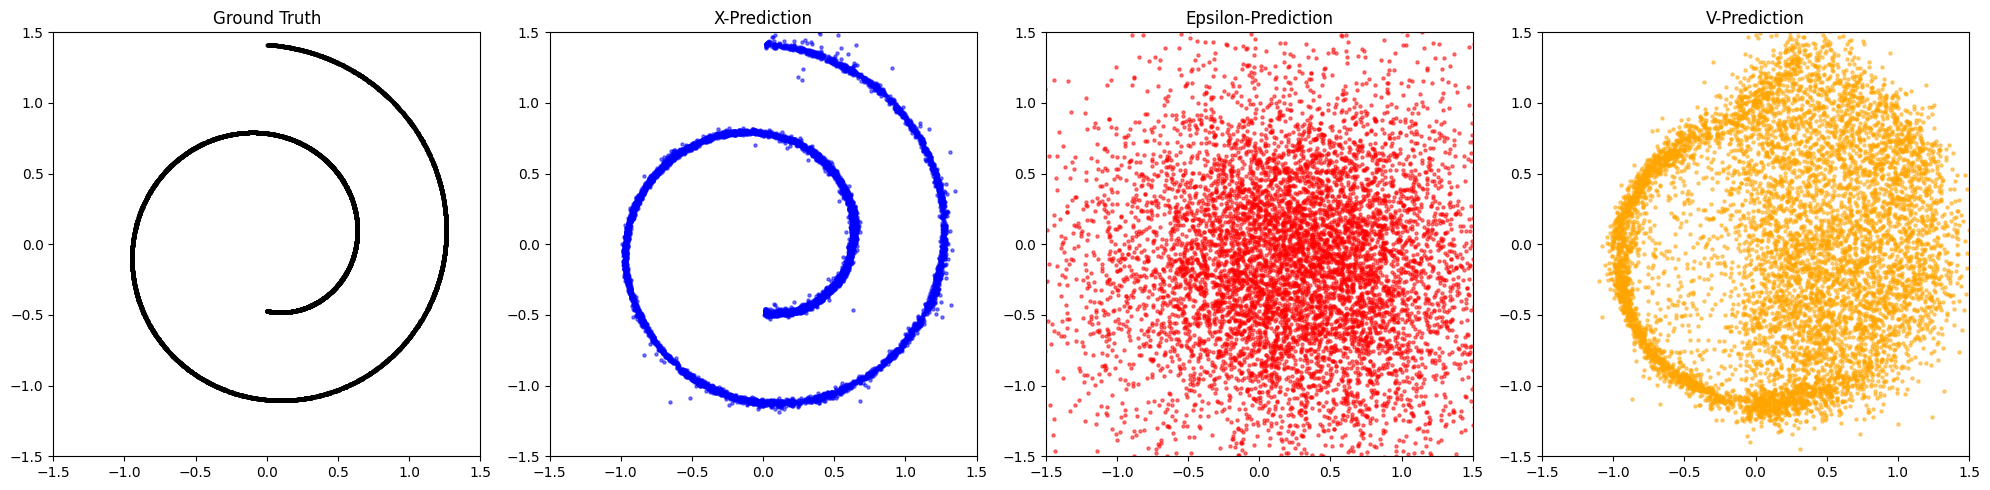

In [96]:
# ==========================================
# 7. Plot
# ==========================================
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].scatter(x_orig[:,0], x_orig[:,1], s=5, c='black', alpha=0.5)
axes[0].set_title("Ground Truth")

axes[1].scatter(x_pred_x[:,0], x_pred_x[:,1], s=5, c='blue', alpha=0.5)
axes[1].set_title("X-Prediction")

axes[2].scatter(x_pred_eps[:,0], x_pred_eps[:,1], s=5, c='red', alpha=0.5)
axes[2].set_title("Epsilon-Prediction")

axes[3].scatter(x_pred_v[:,0], x_pred_v[:,1], s=5, c='orange', alpha=0.5)
axes[3].set_title("V-Prediction")

for ax in axes:
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)

plt.tight_layout()
plt.show()